In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# For a bit more data exploration
import pygraphviz as pgv  # For regression trees
from sklearn.tree import DecisionTreeRegressor  # Import Decision Tree Regressor
from sklearn.tree import export_graphviz

import seaborn as sns
sns.set(style="ticks", color_codes=True)

%matplotlib inline

# Introduction

Discretize continuous data for discrete Bayesian Network development.

Uses continuous data created in notebook 03_select_features_xval_setup.

Created by Leah JB. Part of the ERA4CS WATExR project.

# User input

In [3]:
# User input
met_source = "metno"  # Choose one of: 'metno', 'era5'

# File paths to input data
cont_all_fpath = r"../Data/DataMatrices/forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_all.csv" % met_source
cont_cyano_colour_fpath = r"../Data/DataMatrices/forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_cyanoColour_allVars.csv" %met_source
cont_cyano_colour_directVars_fpath = r"../Data/DataMatrices/forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_cyanoColour_directVars.csv" %met_source
cont_df_noCyano_fpath = r"../Data/DataMatrices/forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_noCyano.csv" %met_source

# Output folders
out_file = r"../Data/DataMatrices"
graph_outfolder = r"../Figures"

# Read in continuous data

In [4]:
cont_df = pd.read_csv(cont_all_fpath, index_col=0, parse_dates=True)
cont_df_cyano_colour = pd.read_csv(cont_cyano_colour_fpath, index_col=0, parse_dates=True)
cont_df_cyano_colour_directVars = pd.read_csv(cont_cyano_colour_directVars_fpath, index_col=0, parse_dates=True)
cont_df_noCyano = pd.read_csv(cont_df_noCyano_fpath, index_col=0, parse_dates=True)

# Picking class boundaries: make regression trees

The 3 response variables TP, chl-a and cyanobacteria will be discretized using WFD-relevant class boundaries. For lake colour, use the 66th percentile. For all the explanatory variables, we need to pick class boundaries to use. Do this using regression tree analysis primarily. I also plotted scatter plots, to make sure results looked sensible (code not included here).

## Regression trees

In [5]:
# Dictionary with key = target var; returns list of potential explanatory vars
xy_dict = {
    "TP": ["TP_prevSummer", "wind_speed"],
    "colour": ["colour_prevSummer", "rain"],
    "chla": ["TP", "chla_prevSummer", "wind_speed"],
    "cyano": ["chla", "colour"],
}

# Make regression trees, one for each pair of explanatory - dependent variable
for targetvar in xy_dict.keys():
    for xvar in xy_dict[targetvar]:
        temp_df = cont_df[[targetvar] + [xvar]].dropna()
        y = temp_df[targetvar].values  # Target variable data
        y = y.reshape(-1, 1)
        X = temp_df[xvar].values  # Explanatory var data
        X = X.reshape(-1, 1)
        regressor = DecisionTreeRegressor(
            random_state=0,
            max_depth=4,
            min_samples_split=6,
            min_samples_leaf=3,
            max_leaf_nodes=8,
        )
        regressor.fit(X, y)

        # export the decision tree to a tree.dot file for visualizing the plot anywhere
        dot_fpath = os.path.join(
            graph_outfolder,
            "Discretization_regTrees/Pairwise/DotFiles/%s_6Mseasons_%s-%s.dot"
            % (met_source, targetvar, xvar),
        )
        export_graphviz(regressor, out_file=dot_fpath, feature_names=[xvar])

        # Convert .dot file to .png
        png_fpath = os.path.join(
            graph_outfolder,
            "Discretization_regTrees/Pairwise/6MSeasons/%s/6MSeasons_%s-%s.png"
            % (met_source, targetvar, xvar),
        )
        pgv.AGraph(dot_fpath).draw(png_fpath, format="png", prog="dot")

In [6]:
# For growing season colour, use 66th percentile rather than RT-derived value from lake colour - cyano relationship?
for var in ["colour"]:
    print("66th percentile for %s: %s" % (var, cont_df[var].quantile(0.66)))

66th percentile for colour: 47.27


In [7]:
# For wind speed, no obvious step change on scatter plot, and regression tree-based boundary makes
# unbalanced classes. Try just median instead

for var in ["wind_speed"]:
    print("Median %s: %s" % (var, cont_df[var].quantile(0.5)))

Median wind_speed: 3.555706521739131


## Boundaries picked

In [8]:
bound_dict = {
             'TP': [29.5],  # No data below 20, so drop this class boundary. 29.5 is middle of 'Mod' class
             'TP_prevSummer': [29.5],  # From RT
             'chla': [20.0],  # WFD boundaries: [10.5, 20.0]. But only 6 values under 10.5 so merge G and M classes.
                              # For predicting cyano, would be better 17.4
             'chla_prevSummer': [16.8],  # from RT
             'colour': [48.0],  # 51.2: class purely for cyano prediction from RT, 48.0: 66th percentile used in GBN analysis
             'colour_prevSummer': [32.6, 61.0],
             'cyano': [1.0],  # M-P boundary is 2.0, but there were only 2 values in this class. Plenty above 2 tho.
             'rain': [497],
             'wind_speed': [3.56],  # [3.64] from regression tree (mean of TP and chla), but classes too unbalanced
            }

# Add wind speed threshold, which depends on whether met.no or era5 is being used
wind_speed_dict = {'metno': [3.56], 'era5': [2.5]}
bound_dict['wind_speed'] = wind_speed_dict[met_source]

bound_dict_terciles = {}

for var in cont_df.columns:
    bound_dict_terciles[var] = [cont_df[var].quantile(0.333),
                                cont_df[var].quantile(0.667)]

bound_dict_terciles

{'chla': [12.604585714285715, 17.583654571428575],
 'chla_prevSummer': [12.63466666631, 17.583654571428575],
 'colour': [27.549924603929046, 47.74483333333334],
 'colour_prevSummer': [26.92525000035667, 47.74483333333334],
 'cyano': [0.548996, 2.6439600000000003],
 'rain': [461.09294967050795, 557.514145479787],
 'TP': [27.17973333333333, 31.32375],
 'TP_prevSummer': [27.249075, 31.796437577639754],
 'wind_speed': [3.493646195652175, 3.6434983695652186]}

## Histograms with boundaries

Plot histograms of the data, with the chosen boundaries drawn on. Also plot simple terciles for comparison. The boundary choices look good.

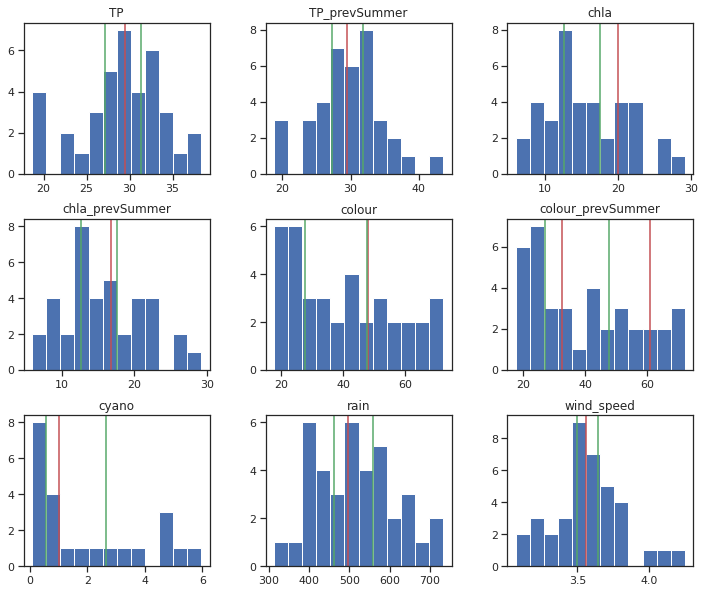

In [9]:
axes = cont_df.sort_index(axis=1).hist(bins=12, figsize=(12, 10), grid=False)

# For each subplot, add on vertical lines for the proposed class boundaries
# N.B. assumes order of plots is the same as the order of keys in bound_dict
var_li = sorted(list(bound_dict.keys()))

for i, ax in enumerate(axes.flatten()):
    if i < 11:
        lines = bound_dict[var_li[i]]
        for line in lines:
            ax.axvline(x=line, color='r')
        tercile_lines = bound_dict_terciles[var_li[i]]
        for tercLine in tercile_lines:
            ax.axvline(x=tercLine, color='g')

plt.show()

# Discretize and write to csv

In [10]:
def discretize(thresholds, value):

    if np.isnan(value):
        return np.NaN

    factor_li_dict = {
        2: ["L", "H"],
        3: ["L", "M", "H"],
        4: ["VL", "L", "M", "H"],
        5: ["VL", "L", "M", "H", "VH"],
    }

    n_classes = len(thresholds) + 1

    for i, boundary in enumerate(thresholds):

        if value < boundary:
            return factor_li_dict[n_classes][i]
            break  # Break out of loop

        # If we're up to the last class boundary, and the value is bigger than it, value is in the uppermost class
        if i + 1 == len(thresholds) and value >= boundary:
            return factor_li_dict[n_classes][i + 1]

In [11]:
cont_df_li = [
    cont_df,
    cont_df_cyano_colour,
    cont_df_cyano_colour_directVars,
    cont_df_noCyano,
]
fname_suffix_li = ["all", "cyano_colour_allVars", "cyano_colour_localVars", "noCyano"]

# Dictionary for storing different discretized dfs.
# Key: data included (all data, all data from when cyano measured, just cyano-related vars, no cyano vars;
# from fname_suffix_li). Returns discretized df based on WFD and regression-tree class boundaries
disc_rt_dict = {}

for i, df in enumerate(cont_df_li):

    # Create empty dataframe to be populated with discretized data
    disc_df = pd.DataFrame(index=df.index, columns=df.columns)

    for var in df.columns:
        disc_df[var] = df[var].apply(lambda x: discretize(bound_dict[var], x))

    # Store in dictionary
    disc_rt_dict[fname_suffix_li[i]] = disc_df

    # Write to csv
    fname = os.path.join(
        out_file,
        "Discretized/%s/Discretized_RegTree_%s.csv" % (met_source, fname_suffix_li[i]),
    )
    disc_df.to_csv(fname)

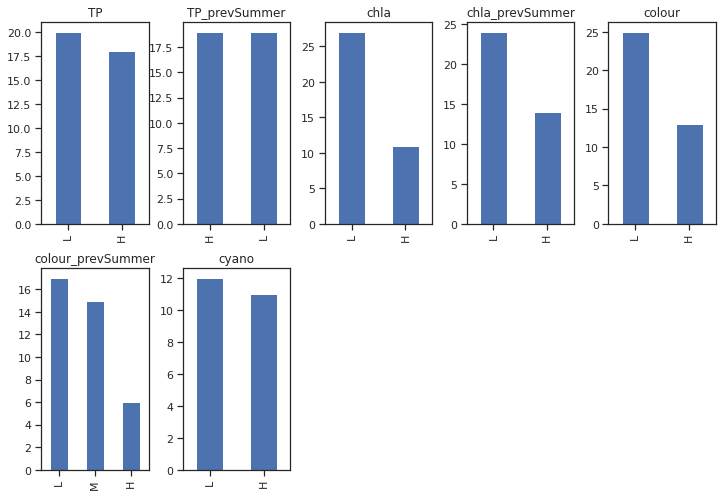

In [12]:
# How balanced are the classes?

# 1) All data and time
disc_df = disc_rt_dict['all'].sort_index(axis=1)

fig, ax = plt.subplots(2, 5, figsize=(10,7))
ax = ax.flatten()
for i, categorical_feature in enumerate(disc_df.columns):
    disc_df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)

for axi in ax[-3:]:
    fig.delaxes(axi)
plt.tight_layout()
plt.savefig(os.path.join(graph_outfolder, 'Vansjø_discretized_wholePeriod_class-counts_%s.png' %met_source))

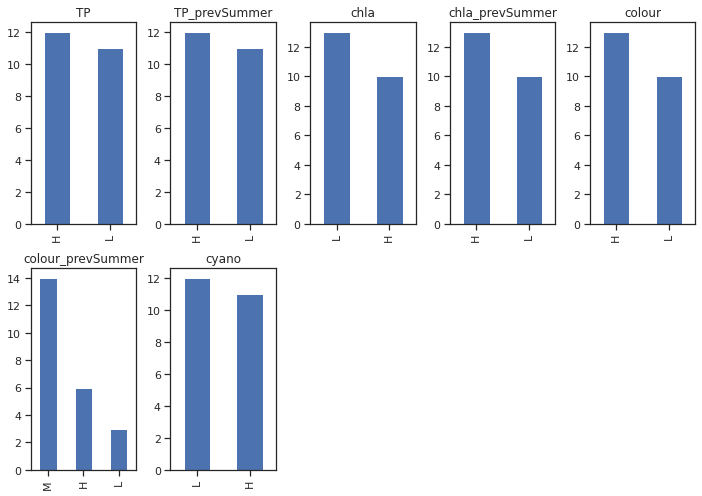

In [13]:
# 1) Cyano and colour df
disc_df = disc_rt_dict['cyano_colour_allVars'].sort_index(axis=1)

fig, ax = plt.subplots(2, 5, figsize=(10, 7))
ax = ax.flatten()
for i, categorical_feature in enumerate(disc_df.columns):
    disc_df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)

for axi in ax[-3:]:
    fig.delaxes(axi)
plt.tight_layout()

met.no wind speed and rain are very unbalanced for the post 1996 period. i.e. it was basically pretty calm and rainy relative to earlier. So we're just looking mostly at that step-change in these class breaks.

Previous summer colour probably has too many classes too, the low class doesn't have many values. It will do for starters though.